## 1

In [1]:
!pip install camb

     |████████████████████████████████| 1.6 MB 9.8 MB/s 
  Created wheel for camb: filename=camb-1.3.2-py3-none-any.whl size=1009274 sha256=d5071f054aae282ed75c577aaab9b2b82e660052cf6675e83bafc9cdbcf97a02
  Stored in directory: /root/.cache/pip/wheels/d3/c1/34/87632240be4218d112bc9b47c18e92ef81bfb6bc1e1f0f0a72
Successfully built camb


chisq is  15267.937674122833  for  2501  degrees of freedom.


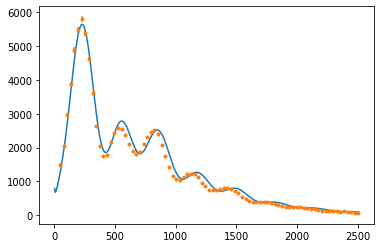

In [3]:
import numpy as np
import camb
from matplotlib import pyplot as plt
import time


def get_spectrum(pars,lmax=3000):
    #print('pars are ',pars)
    H0=pars[0]
    ombh2=pars[1]
    omch2=pars[2]
    tau=pars[3]
    As=pars[4]
    ns=pars[5]
    pars=camb.CAMBparams()
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(pars)
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[:,0]    #you could return the full power spectrum here if you wanted to do say EE
    return tt[2:]


plt.ion()

pars=np.asarray([60,0.02,0.1,0.05,2.00e-9,1.0])
planck=np.loadtxt('COM_PowerSpect_CMB-TT-full_R3.01.txt',skiprows=1)
ell=planck[:,0]
spec=planck[:,1]
errs=0.5*(planck[:,2]+planck[:,3]);
model=get_spectrum(pars)
model=model[:len(spec)]
resid=spec-model
chisq=np.sum( (resid/errs)**2)
print("chisq is ",chisq," for ",len(resid)-len(pars)," degrees of freedom.")
#read in a binned version of the Planck PS for plotting purposes
planck_binned=np.loadtxt('COM_PowerSpect_CMB-TT-binned_R3.01.txt',skiprows=1)
errs_binned=0.5*(planck_binned[:,2]+planck_binned[:,3]);
plt.clf()
plt.plot(ell,model)
plt.errorbar(planck_binned[:,0],planck_binned[:,1],errs_binned,fmt='.')
plt.show()

In [4]:
type(chisq)

numpy.float64

As we see, this set of parameters ([60,0.02,0.1,0.05,2.00e-9,1.0]) are not an acceptable fit!
We now try the this set of parameters:
[69, 0.022, 0.12, 0.06, 2.1e-9, 0.95]

In [5]:
pars=np.asarray([69, 0.022, 0.12, 0.06, 2.1e-9, 0.95])
planck=np.loadtxt('COM_PowerSpect_CMB-TT-full_R3.01.txt',skiprows=1)
ell=planck[:,0]
spec=planck[:,1]
errs=0.5*(planck[:,2]+planck[:,3]);
model=get_spectrum(pars)
model=model[:len(spec)]
resid=spec-model
chisq=np.sum( (resid/errs)**2)
print("chisq is ",chisq," for ",len(resid)-len(pars)," degrees of freedom.")

chisq is  3272.2036740262683  for  2501  degrees of freedom.


So the chi-square is 3272.2036740262683 but it is again too much! So this is not an acceptable fit too.


## 2

In [6]:
def get_spectrum_2(pars, lmax=3000):
  model=get_spectrum(pars)
  model=model[:len(spec)]
  return model

In [7]:
get_spectrum_2([69, 0.022, 0.12, 0.06, 2.1e-9, 0.95])

array([1127.74053046, 1058.88801604,  994.68866218, ...,   70.56294406,
         70.37492505,   70.18872273])

In [28]:
pars=np.asarray([69, 0.023, 0.14, 0.07, 2.1e-9, 0.95])

In [30]:
pars=np.asarray([69, 0.023, 0.12, 0.06, 2.1e-9, 0.95])
pars_minus= pars.copy()
pars_positive = pars.copy()
delta_rate = 0.01
A=np.zeros((6, len(spec)))

for i in range(0, 5):
  pars_minus[i] = (1- delta_rate)*pars[i]
  pars_positive[i] = (1+delta_rate)*pars[i]
  A[i, :]= (get_spectrum_2(pars_minus)-get_spectrum_2(pars_positive))/(2*delta_rate*pars[i])

In [31]:
A= np.matrix(A).transpose()

u, s, vt= np.linalg.svd(A, False)
sinv= np.matrix(np.diag(1/s))
fitp=vt.transpose()*sinv*(u.transpose()*r)

In [ ]:
sinv= numpy.matrix(np.diag(1/s))

In [20]:
N = np.zeros((len(spec),len(spec)))
for j in range(0, len(spec)-1):
  N[j, j]= 1/(errs[j]**2)

In [34]:
m = pars.copy()

while(True):
  for i in range(0, 5):
    m_minus = m.copy()
    m_positive = m.copy()
    m_minus[i] = (1 - delta_rate) *m[i]
    m_positive[i] = (1 + delta_rate)*m[i]
    A[i, :]= (get_spectrum_2(m_minus)-get_spectrum_2(m_positive))/(2*delta_rate*m[i])

  r= spec - get_spectrum_2(m)
  #B= np.linalg.inv(np.matmul(np.matmul(A, N), np.transpose(A)))
  #C= np.matmul(np.matmul(A, N), r)
  r=np.matrix(r)
  A= np.matrix(A).transpose()
  u, s, vt= np.linalg.svd(A, False)
  print(vt.shape(), u.shape(), s.shape())
  sinv= np.matrix(np.diag(1/s))
  delta_m=vt.transpose()*sinv*(u.transpose()*r)
  #delta_m = np.matmul(B,C)
  chi = np.matmul(np.matmul(np.transpose(A), N), r)
  if chi < 0.001:
    break
  delta_m = np.asarray(delta_m).reshape(-1)
  m = m + delta_m

ValueError: ignored

In [ ]:
f = open(planck_fit_params.txt ,'w')
f.write(m)
f.close()

## 3

Since I could not end the section number 2 because of the singular matrix problem, I will run a built-in fuction of python to fit the parameters and start my mcmc chain.